In [ ]:
import numpy as np
from numpy import linalg as la
from matplotlib import pyplot as plt
from matplotlib import rcParams
from scipy import io
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D
import gdown

In [ ]:
# download data file from Google Drive

data_url =   'https://drive.google.com/file/d/1uwmI6bzLFUHVaS7wJBm3Ba6Pms5Bg4r5/view?usp=sharing'
output = 'AirfoilData.npz'
gdown.download(data_url, output, quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1uwmI6bzLFUHVaS7wJBm3Ba6Pms5Bg4r5
To: /content/AirfoilData.npz
100%|██████████| 20.0M/20.0M [00:00<00:00, 70.7MB/s]


'AirfoilData.npz'

In [ ]:
data = np.load('/content/AirfoilData.npz')
Data = data['DataMat'] # Vorticity data (2d array)
X = data['X']
Y = data['Y']
time =  data['time']
Lift =  data['Lift']
Drag =  data['Drag']

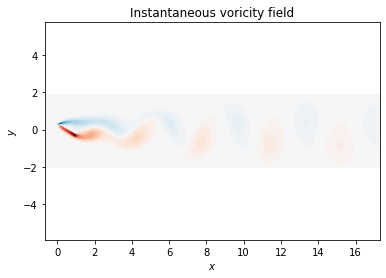

In [ ]:
# Pick an instance in time, and visualize
# (first rearrange vector to a 2d array)
timeindex = 0;
ny, nx = X.shape
nspace, ntime = Data.shape
# First subtract mean data
DataMean = np.mean(Data,axis=1)
DataSub = Data - np.tile(DataMean[:,np.newaxis],(1,ntime))

DataReshape = np.reshape(Data[:,timeindex],(ny,nx))


clevels = np.linspace(-10,10,50)
plt.contourf(X,Y,DataReshape,clevels,cmap="RdBu_r")
plt.axis('equal')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Instantaneous voricity field');

In [ ]:
# Build a simple autoencoder

inputs = keras.Input(shape = (nspace,))

# add a hidden layer
encodedDim = 4
hiddenLayer = layers.Dense(encodedDim,activation ='linear')
#hiddenLayer = layers.Dense(encodedDim,activation ='tanh')

encoding = hiddenLayer(inputs)
encoder = keras.Model(inputs,encoding,name="encoder")
print(encoder.summary())

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 45000)]           0         
                                                                 
 dense (Dense)               (None, 4)                 180004    
                                                                 
Total params: 180,004
Trainable params: 180,004
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# decoder

decoder_input = layers.Input(shape = (encodedDim,))
# add output layer
outputlayer = layers.Dense(nspace,activation = 'linear')
#outputlayer = layers.Dense(nspace,activation = 'tanh')#
outputs = outputlayer(decoder_input)

decoder = keras.Model(decoder_input,outputs,name="decoder")
print(decoder.summary())

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_1 (Dense)             (None, 45000)             225000    
                                                                 
Total params: 225,000
Trainable params: 225,000
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# define autoencoder

output_auto = decoder(encoder(inputs)) # xapprox = g(f(x))

model = models.Model(inputs,output_auto)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 45000)]           0         
                                                                 
 encoder (Functional)        (None, 4)                 180004    
                                                                 
 decoder (Functional)        (None, 45000)             225000    
                                                                 
Total params: 405,004
Trainable params: 405,004
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
TrainingInputs = np.transpose(DataSub)
TrainingOutputs = np.transpose(DataSub)
model.compile(loss = 'mse',optimizer='adam')

history = model.fit(TrainingInputs,TrainingOutputs,batch_size=62,epochs = 200)

Epoch 1/200
1/1 [==============================] - 5s 5s/step - loss: 0.0980
Epoch 2/200
1/1 [==============================] - 0s 176ms/step - loss: 0.0987
Epoch 3/200
1/1 [==============================] - 0s 147ms/step - loss: 0.0984
Epoch 4/200
1/1 [==============================] - 0s 256ms/step - loss: 0.0978
Epoch 5/200
1/1 [==============================] - 0s 239ms/step - loss: 0.0972
Epoch 6/200
1/1 [==============================] - 0s 433ms/step - loss: 0.0966
Epoch 7/200
1/1 [==============================] - 0s 296ms/step - loss: 0.0959
Epoch 8/200
1/1 [==============================] - 0s 255ms/step - loss: 0.0952
Epoch 9/200
1/1 [==============================] - 0s 292ms/step - loss: 0.0944
Epoch 10/200
1/1 [==============================] - 0s 223ms/step - loss: 0.0937
Epoch 11/200
1/1 [==============================] - 0s 413ms/step - loss: 0.0930
Epoch 12/200
1/1 [==============================] - 0s 232ms/step - loss: 0.0922
Epoch 13/200
1/1 [======================

2/2 [==============================] - 0s 11ms/step


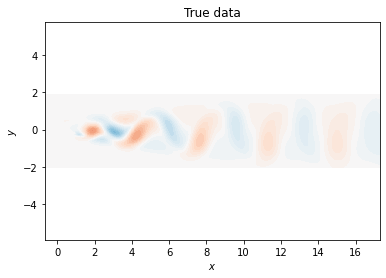

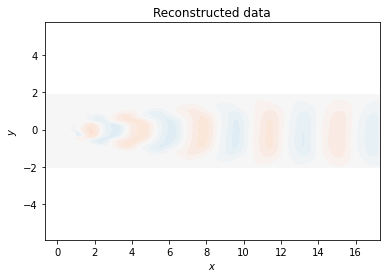

In [ ]:
TestData = np.transpose(DataSub)

ReconstructedData = model.predict(TestData)
ReconstructedDataT = np.transpose(ReconstructedData)

# plot reconstructed data for a specific timestep

timeStep = 20

DataReshape = np.reshape(DataSub[:,timeStep],(ny,nx))
DataReshapeRecon = np.reshape(ReconstructedDataT[:,timeStep],(ny,nx))

clevels = np.linspace(-4,4,50)
plt.contourf(X,Y,DataReshape,clevels,cmap="RdBu_r")
plt.axis('equal')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('True data');
plt.show()

plt.contourf(X,Y,DataReshapeRecon,clevels,cmap="RdBu_r")
plt.axis('equal')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Reconstructed data');

In [ ]:
# Look at using SVD instead

U,Sigma,Vt = la.svd(DataSub,full_matrices=0)

Ur = U[:,:encodedDim]
Vtr = Vt[:encodedDim,:]
Sigmar = np.diag(Sigma[:encodedDim])

In [ ]:
ErrorSVD = np.linalg.norm(DataSub-Ur@Sigmar@Vtr)
print(ErrorSVD/(nspace*ntime))
ErrorAE = np.linalg.norm(DataSub-ReconstructedDataT)
print(ErrorAE/(nspace*ntime))

2.4997204486713893e-05
0.00010296445927053504


(-0.66, 17.3, -2.06, 1.9)

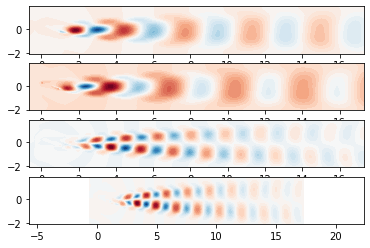

In [ ]:
# Plot basis for encoded space 
# For SVD, these are left singular vectors

SVDmode1 = np.reshape(Ur[:,0],(ny,nx))
SVDmode2 = np.reshape(Ur[:,1],(ny,nx))
SVDmode3 = np.reshape(Ur[:,2],(ny,nx))
SVDmode4 = np.reshape(Ur[:,3],(ny,nx))

figs, axs = plt.subplots(4,1)
nlevels = 50
axs[0].contourf(X,Y,SVDmode1,nlevels,cmap="RdBu_r")
plt.axis('equal')
axs[1].contourf(X,Y,SVDmode2,nlevels,cmap="RdBu_r")
plt.axis('equal')
axs[2].contourf(X,Y,SVDmode3,nlevels,cmap="RdBu_r")
plt.axis('equal')
axs[3].contourf(X,Y,SVDmode4,nlevels,cmap="RdBu_r")
plt.axis('equal')

1/1 [==============================] - 0s 41ms/step


(-0.66, 17.3, -2.06, 1.9)

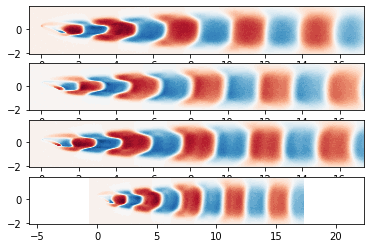

In [ ]:
# Visualize autoencoder encoding

# decode unit vectors in encoded space (1,0,0,0) etc,

toDecode = np.diag(np.ones((encodedDim,)))
AEmodes = decoder.predict(toDecode)
AEmode1 = np.reshape(AEmodes[0,:],(ny,nx))
AEmode2 = np.reshape(AEmodes[1,:],(ny,nx))
AEmode3 = np.reshape(AEmodes[2,:],(ny,nx))
AEmode4 = np.reshape(AEmodes[3,:],(ny,nx))

figs, axs = plt.subplots(4,1)
nlevels = 50
axs[0].contourf(X,Y,AEmode1,nlevels,cmap="RdBu_r")
plt.axis('equal')
axs[1].contourf(X,Y,AEmode2,nlevels,cmap="RdBu_r")
plt.axis('equal')
axs[2].contourf(X,Y,AEmode3,nlevels,cmap="RdBu_r")
plt.axis('equal')
axs[3].contourf(X,Y,AEmode4,nlevels,cmap="RdBu_r")
plt.axis('equal')
